In [67]:
import numpy as np

class VectorizedMLR:
    """
    Multiple Linear Regression: ŷ = X@wᵀ + b

    Works for ANY number of features:
        - p = 1: Simple Linear Regression
        - p > 1: Multiple Linear Regression

    REQUIRED Dimensions:
        X: (n, p) - n observations, p features
        w: (1, p) - 1 row, p features (ROW VECTOR)
        b: scalar
        ŷ: (n,1) - n predictions
    """

    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None  # Will be (1, p)
        self.b = 0.0
        self.loss_history = []

    def predict(self, X):
        """
        Matrix-based prediction: ŷ = X@wᵀ + b

        Input:
            X: numpy array (n, p)
        Returns:
            y_pred: numpy array (n,1) - predictions
        """
        y_pred = X @ self.w.T + self.b
        return y_pred

    def compute_loss(self, X, y):
        """Mean Squared Error: (1/n) * sum((y_pred - y)^2)"""
        n = X.shape[0]
        y_pred = self.predict(X)
        loss = (1 / n) * np.sum((y_pred - y) ** 2)
        return loss

    def compute_gradients(self, X, y):
        """
        Computes gradients for w and b.
        grad_w = dJ/dw
        grad_b = dJ/db
        """
        n = X.shape[0]
        y_pred = self.predict(X)
        error = y_pred - y # Shape (n, 1)

        # Gradient w:
        # Shape must be (1, p) to match self.w
        # Formula: (2/n) * error.T @ X
        # (1, n) @ (n, p) -> (1, p)
        grad_w = (2 / n) * (error.T @ X)

        # Gradient b:
        # Scalar mean of errors * 2
        grad_b = (2 / n) * np.sum(error)

        return grad_w, grad_b

    def fit(self, X, y):
        """
        Apply gradient descent to optimize the parameters of the model.

        Input:
            X: numpy array (n, p)
            y: numpy array (n, 1)
        Returns:
            self for chained calls.
        """
        n_samples, n_features = X.shape
        self.w = np.zeros((1, n_features))
        self.b = 0.0
        self.loss_history = []

        # Gradient Descent Loop
        for i in range(self.num_iterations):
            # Calculate gradients
            grad_w, grad_b = self.compute_gradients(X, y)

            # Update parameters
            self.w = self.w - (self.learning_rate * grad_w)
            self.b = self.b - (self.learning_rate * grad_b)

            # Track loss
            current_loss = self.compute_loss(X, y)
            self.loss_history.append(current_loss)

        return self

In [68]:
# Load Auto MPG dataset
from urllib.request import urlretrieve
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
urlretrieve(url, 'auto-mpg.data')

column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model_year', 'origin', 'car_name']
data = pd.read_csv('auto-mpg.data', names=column_names,
                   delim_whitespace=True, na_values='?')
data = data.dropna()

# Extract target
y = data['mpg'].values.reshape(-1,1)

print(f"Dataset: {len(y)} cars")
print(f"y shape: {y.shape}")

Dataset: 392 cars
y shape: (392, 1)


/tmp/ipython-input-322/2949022177.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('auto-mpg.data', names=column_names,


In [69]:
# ============================================================
# Simple Linear Regression: One feature (weight → mpg)
# ============================================================
from sklearn.preprocessing import MinMaxScaler

# Extract weight and reshape to (n, 1) - MUST be 2D!
X_slr = data['weight'].values / 1000  # Scale to thousands
X_slr = X_slr.reshape(-1, 1)  # Shape: (n, 1) - single feature

# normalize
scaler = MinMaxScaler()
scaler.fit(X_slr)
X_slr = scaler.transform(X_slr)

print(f"\n" + "="*60)
print("SIMPLE LINEAR REGRESSION (1 feature)")
print("="*60)
print(f"X_slr shape: {X_slr.shape}")  # Should be (n, 1)
print(f"y shape: {y.shape}")          # Should be (n,1)

# Train model
slr_model = VectorizedMLR(learning_rate=0.1, num_iterations=1000)
slr_model.fit(X_slr, y)

print(f"\nResults:")
print(f"weights shape: {slr_model.w.shape}")  # Should be (1, 1)
print(f"Weight (w): {slr_model.w[0, 0]:.4f} (MPG per 1000 lbs)")
print(f"Bias (b): {slr_model.b:.4f}")
print(f"Final MSE: {slr_model.loss_history[-1]:.4f}")


SIMPLE LINEAR REGRESSION (1 feature)
X_slr shape: (392, 1)
y shape: (392, 1)

Results:
weights shape: (1, 1)
Weight (w): -26.9707 (MPG per 1000 lbs)
Bias (b): 33.8807
Final MSE: 18.6766


In [70]:
import numpy as np

class minMaxScaler:
    def __init__(self):
        self.min = None # this should be a row vector sized (1,features)
        self.max = None # this should be a row vector sized (1,features)

    def fit(self, X):
        """
        get min and max from training data.
        X: (n, p) numpy array
        """
        # be sure to find the min and max along the correct axis
        # Want min and max in each column (features)
        # numpy refers to this as finding the min or max ALONG the row (axis=0)
        self.min = X.min(axis=0).reshape(1,-1)
        self.max = X.max(axis=0).reshape(1,-1)
        # the reshape says we want a 2D matrix with
        # 1 row that has "don't care" how many columns

    def transform(self, X):
        """
        Apply the learned scaling to data.
        X: (n, p) numpy array
        Returns: scaled X with same shape
        """
        X_scaled = (X - self.min) / (self.max - self.min)
        return X_scaled

In [71]:
# ============================================================
# Multiple Linear Regression: three features → mpg
# ============================================================

# Extract multiple features - already 2D!
X_mlr = data[['weight', 'horsepower']].values

scaler = minMaxScaler()
scaler.fit(X_mlr)
X_mlr = scaler.transform(X_mlr)

print(f"\n" + "="*60)
print("MULTIPLE LINEAR REGRESSION (2 features)")
print("="*60)
print(f"X_mlr shape: {X_mlr.shape}")  # Should be (n, 3)
print(f"y shape: {y.shape}")          # Should be (n,1)

# Train model - EXACT SAME CODE!
mlr_model = VectorizedMLR(learning_rate=0.1, num_iterations=1000)
mlr_model.fit(X_mlr, y)

print(f"\nResults:")
print(f"Theta shape: {mlr_model.w.shape}")  # Should be (1, 3)
print(f"Weights (w):")
print(f"  Weight:       {mlr_model.w[0, 0]:7.4f} (per 1000 lbs)")
print(f"  Horsepower:   {mlr_model.w [0, 1]:7.4f} (per 100 hp)")
print(f"Bias (b): {mlr_model.b:.4f}")
print(f"Final MSE: {mlr_model.loss_history[-1]:.4f}")


MULTIPLE LINEAR REGRESSION (2 features)
X_mlr shape: (392, 2)
y shape: (392, 1)

Results:
Theta shape: (1, 2)
Weights (w):
  Weight:       -19.2731 (per 1000 lbs)
  Horsepower:   -10.0712 (per 100 hp)
Bias (b): 34.1028
Final MSE: 17.8631


In [72]:
# ============================================================
# Multiple Linear Regression: all features → mpg
# ============================================================

# Extract multiple features - already 2D!
# correct this to select the appropriate columns from the pandas dataframe.
# Refer to the selection code used above and
# the feature list shown in the code for downloading the dataset.
# do not include the MPG column or the car_name column.
X_mlr_all = data[['cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model_year']].values

# normalize
scaler = minMaxScaler()
scaler.fit(X_mlr_all)
X_mlr_all = scaler.transform(X_mlr_all)

print(f"\n" + "="*60)
print("MULTIPLE LINEAR REGRESSION (all features)")
print("="*60)
print(f"X_mlr_all shape: {X_mlr_all.shape}")  # Should be (n, 7)
print(f"y shape: {y.shape}")          # Should be (n,1)

# Train model - EXACT SAME CODE!
mlr_all_model = VectorizedMLR(learning_rate=0.1, num_iterations=1000)
mlr_all_model.fit(X_mlr_all, y)

print(f"\nResults:")
print(f"Theta shape: {mlr_all_model.w.shape}")  # Should be (1, 7)
print(f"Final MSE: {mlr_all_model.loss_history[-1]:.4f}")


MULTIPLE LINEAR REGRESSION (all features)
X_mlr_all shape: (392, 6)
y shape: (392, 1)

Results:
Theta shape: (1, 6)
Final MSE: 11.8372


In [73]:
def compute_mse(y_true, y_pred):
    """
    Mean Squared Error

    Inputs:
        y_true: numpy array (n,1)
        y_pred: numpy array (n,1)
    Returns:
        mse: scalar
    """
    # Calculate the squared differences
    squared_errors = (y_true - y_pred) ** 2

    # Calculate the mean
    mse = np.mean(squared_errors)

    return mse


def compute_r_squared(y_true, y_pred):
    """
    Coefficient of Determination (R²)

    R² = 1 - (MSE_model / MSE_baseline)

    Where:
        MSE_model = mean((y_true - y_pred)²)
        MSE_baseline = mean((y_true - ȳ)²) : ȳ is mean of y values

    Interpretation:
        R² = 1.0  → perfect predictions
        R² = 0.0  → model is only as good as always predicting the mean
        R² < 0.0  → model is worse than predicting the mean (bad!)

    R² measures the proportion of variance in y explained by the model.

    Inputs:
        y_true: numpy array (n,) or (n, 1)
        y_pred: numpy array (n,) or (n, 1)
    Returns:
        r_squared: scalar
    """

    # Calculate MSE_model (Variance of the residuals)
    mse_model = np.mean((y_true - y_pred) ** 2)

    # Calculate MSE_baseline (Variance of the data)
    # The baseline model always predicts the mean of the target (y_true)
    y_mean = np.mean(y_true)
    mse_baseline = np.mean((y_true - y_mean) ** 2)

    # Calculate R

    r_squared = 1 - (mse_model / mse_baseline)

    return r_squared

In [74]:
# Get predictions
y_pred_slr = slr_model.predict(X_slr)
y_pred_mlr = mlr_model.predict(X_mlr)
y_pred_mlr_all = mlr_all_model.predict(X_mlr_all)

# Compute metrics
print("\n" + "="*70)
print("MODEL COMPARISON: Does Adding Features Improve Performance?")
print("="*70)

print("\nSIMPLE Linear Regression (vehicle weight only):")
mse_slr = compute_mse(y, y_pred_slr)
r2_slr = compute_r_squared(y, y_pred_slr)
print(f"  Features: 1 (vehicle weight)")
print(f"  MSE:      {mse_slr:.4f}")
print(f"  R²:       {r2_slr:.4f}")
print(f"  → Explains {r2_slr*100:.1f}% of variance in MPG")

print("\nMULTIPLE Linear Regression (weight + horsepower):")
mse_mlr = compute_mse(y, y_pred_mlr)
r2_mlr = compute_r_squared(y, y_pred_mlr)
print(f"  Features: 3 (vehicle weight, horsepower)")
print(f"  MSE:      {mse_mlr:.4f}")
print(f"  R²:       {r2_mlr:.4f}")
print(f"  → Explains {r2_mlr*100:.1f}% of variance in MPG")

print("\nMULTIPLE Linear Regression (all features):")
mse_mlr_all = compute_mse(y, y_pred_mlr_all)
r2_mlr_all = compute_r_squared(y, y_pred_mlr_all)
print(f"  Features: {X_mlr_all.shape[1]}")
print(f"  MSE:      {mse_mlr_all:.4f}")
print(f"  R²:       {r2_mlr_all:.4f}")
print(f"  → Explains {r2_mlr_all*100:.1f}% of variance in MPG")

print("\n" + "-"*70)
print("IMPROVEMENT FROM ADDING 1 FEATURE:")
print("-"*70)
mse_reduction = mse_slr - mse_mlr
mse_reduction_pct = (mse_reduction / mse_slr) * 100
r2_increase = r2_mlr - r2_slr
r2_increase_pct = ((r2_mlr - r2_slr) / (1 - r2_slr)) * 100

print(f"  MSE reduction:     {mse_reduction:.4f} ({mse_reduction_pct:.1f}% decrease)")
print(f"  R² increase:       {r2_increase:.4f} (explains {r2_increase_pct:.1f}% more of remaining variance)")

if mse_mlr < mse_slr:
    print(f"\n  ✓ Adding horsepower IMPROVED the model!")
else:
    print(f"\n  ✗ Adding features did NOT improve the model (check implementation)")

print("="*70)


MODEL COMPARISON: Does Adding Features Improve Performance?

SIMPLE Linear Regression (vehicle weight only):
  Features: 1 (vehicle weight)
  MSE:      18.6766
  R²:       0.6926
  → Explains 69.3% of variance in MPG

MULTIPLE Linear Regression (weight + horsepower):
  Features: 3 (vehicle weight, horsepower)
  MSE:      17.8631
  R²:       0.7060
  → Explains 70.6% of variance in MPG

MULTIPLE Linear Regression (all features):
  Features: 6
  MSE:      11.8372
  R²:       0.8052
  → Explains 80.5% of variance in MPG

----------------------------------------------------------------------
IMPROVEMENT FROM ADDING 1 FEATURE:
----------------------------------------------------------------------
  MSE reduction:     0.8135 (4.4% decrease)
  R² increase:       0.0134 (explains 4.4% more of remaining variance)

  ✓ Adding horsepower IMPROVED the model!


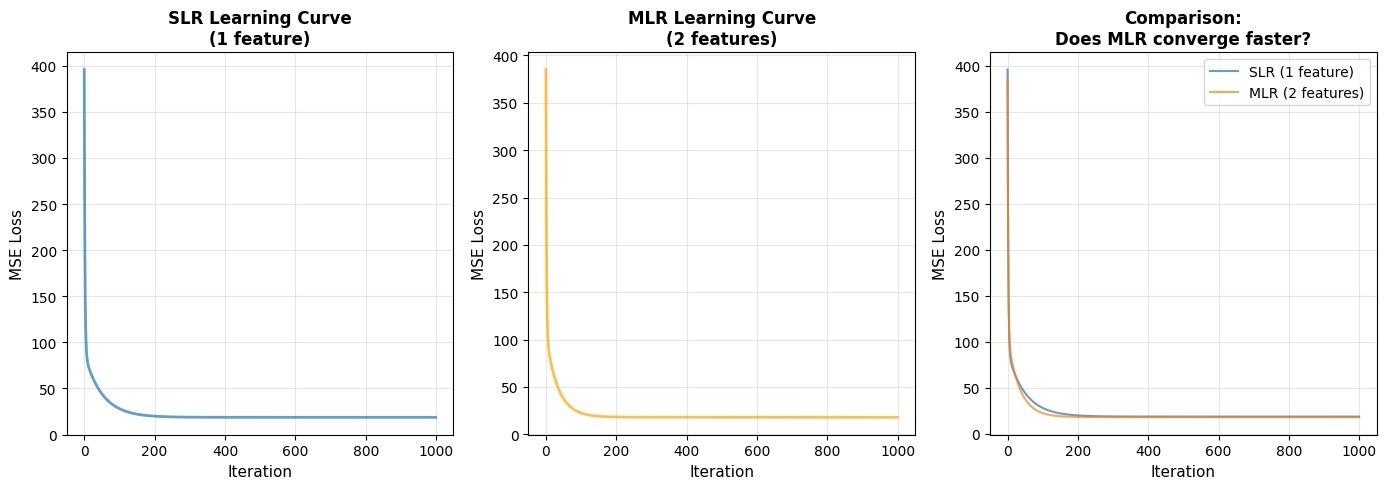

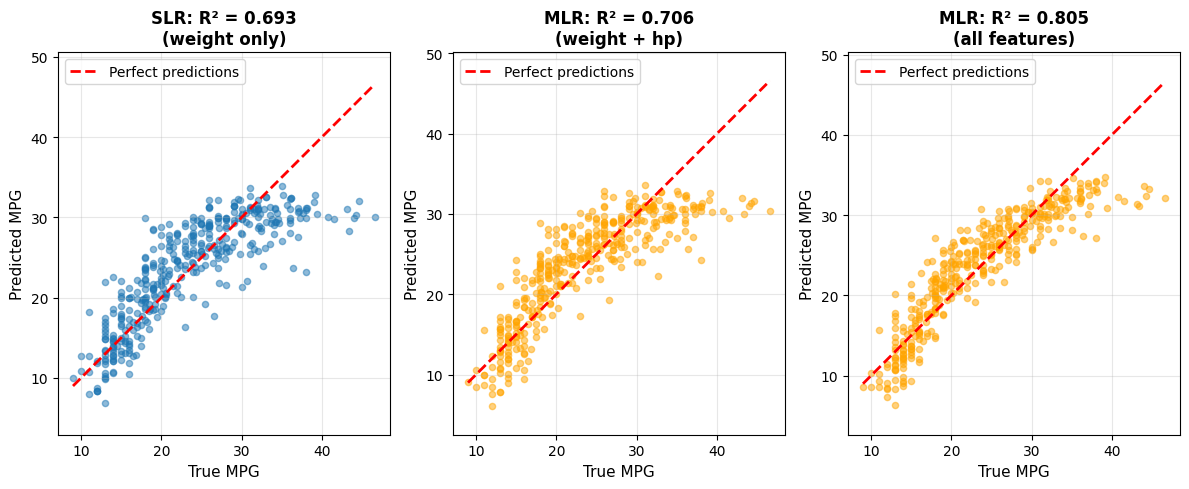

In [75]:
import matplotlib.pyplot as plt

# ============================================================
# Plot 1: Learning Curves - Convergence Comparison
# ============================================================

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(slr_model.loss_history, alpha=0.7, linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('MSE Loss', fontsize=11)
plt.title('SLR Learning Curve\n(1 feature)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(mlr_model.loss_history, alpha=0.7, linewidth=2, color='orange')
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('MSE Loss', fontsize=11)
plt.title('MLR Learning Curve\n(2 features)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(slr_model.loss_history, label='SLR (1 feature)', alpha=0.7)
plt.plot(mlr_model.loss_history, label='MLR (2 features)', alpha=0.7)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('MSE Loss', fontsize=11)
plt.title('Comparison:\nDoes MLR converge faster?', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# Plot 2: Predictions vs. Actual - Accuracy Comparison
# ============================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(y.flatten(), y_pred_slr.flatten(), alpha=0.5, s=20)
plt.plot([y.flatten().min(), y.flatten().max()], [y.flatten().min(), y.flatten().max()], 'r--', lw=2,
         label='Perfect predictions')
plt.xlabel('True MPG', fontsize=11)
plt.ylabel('Predicted MPG', fontsize=11)
plt.title(f'SLR: R² = {r2_slr:.3f}\n(weight only)',
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.scatter(y.flatten(), y_pred_mlr.flatten(), alpha=0.5, s=20, color='orange')
plt.plot([y.flatten().min(), y.flatten().max()], [y.flatten().min(), y.flatten().max()], 'r--', lw=2,
         label='Perfect predictions')
plt.xlabel('True MPG', fontsize=11)
plt.ylabel('Predicted MPG', fontsize=11)
plt.title(f'MLR: R² = {r2_mlr:.3f}\n(weight + hp)',
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.scatter(y.flatten(), y_pred_mlr_all.flatten(), alpha=0.5, s=20, color='orange')
plt.plot([y.flatten().min(), y.flatten().max()], [y.flatten().min(), y.flatten().max()], 'r--', lw=2,
         label='Perfect predictions')
plt.xlabel('True MPG', fontsize=11)
plt.ylabel('Predicted MPG', fontsize=11)
plt.title(f'MLR: R² = {r2_mlr_all:.3f}\n(all features)',
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

Observations to note in your report:

## Convergence: Did both models converge (loss stopped decreasing)? Which converged to a lower loss?

Yes, MLR had less loss without overfitting

## Accuracy: In the predictions vs. actual plot, which model has points closer to the red line?

MLR has more points closer to the red line so it preformed better.


## MSE: How much did adding a single feature reduce the MSE? How about when all features were used?

One feature removed 4% of error. With all of them, we see MSE = 11.8372 which is a much bigger drop.

## Comparison to R^2: How much more of the data’s variance does the 2 feature model explain? How about when all features were used?

one adds= 0.0134
Many adds= 0.1126.
